<a href="https://colab.research.google.com/github/imn22/Audio_denoising/blob/main/Wiener_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pystoi
from pystoi.stoi import stoi

In [ ]:
!pip install pesq
from pesq import pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262923 sha256=35a9b40a7787d5d587f689e9d6de26894eb7e1f382212ddcdf9a4540627b7d94
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import scipy
from IPython.core.display import display
import IPython.display as ipd
from tqdm import tqdm
from scipy.io import wavfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import zipfile
import time
import librosa
import matplotlib

To verify the effectiveness of the proposed framework, the
standard PESQ function was used to measure the speech quality
and the score ranges from -0.5 to 4.5. We also presented STOI
for speech intelligibility evaluation and the score ranges from 0
to 1. Both the two metrics are the higher the better.

In [ ]:
def compute_PESQ(clean_signal, noisy_signal, sr=8000):
    return pesq(sr, clean_signal, noisy_signal, mode='nb')
def compute_STOI(clean_signal, noisy_signal, sr=8000):
    return stoi(clean_signal, noisy_signal, sr, extended=False)

## 1. Data Exploration

In [ ]:
#get the data

zipped_data= '/content/drive/MyDrive/Dlts_project/data.zip'
os.makedirs('/content/data', exist_ok= True)

with zipfile.ZipFile(zipped_data, 'r') as f:
  f.extractall('/content/data')


In [ ]:
root_path = '/content/data/data/'
train_small_path = '/content/data/data/train_small/'
train_path = '/content/data/data/train/'
test_path = '/content/data/data/test/'

In [ ]:
train_clean_folder = os.path.join(train_path, 'original/signal')
train_noisy_folder = os.path.join(train_path, 'noisy/signal')
test_clean_folder = os.path.join(test_path, 'original/signal')
test_noisy_folder = os.path.join(test_path, 'noisy/signal')
print("Number of training samples : ", len(os.listdir(train_noisy_folder) ))
print("Number of testing samples : ", len(os.listdir(test_noisy_folder)))

Number of training samples :  2118
Number of testing samples :  782


In [ ]:
#sample noisy and clean signals
noisy_path = train_small_path + "noisy/signal/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_6_.wav"
clean_path = train_small_path + "original/signal/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_6_.wav"

fs_noisy, sig_noisy = scipy.io.wavfile.read(noisy_path)
fs_clean, sig_clean = scipy.io.wavfile.read(clean_path)

print("noisy singnal:")
display(ipd.Audio(data= sig_noisy, rate= fs_noisy))

print("clean signal:")
display(ipd.Audio(data= sig_clean, rate=fs_clean))

noisy singnal:


clean signal:


In [ ]:
print('signals length :', len(sig_noisy), len(sig_clean))
print('sampling rates :', fs_noisy, fs_clean)

signals length : 80000 80000
sampling rates : 8000 8000


In [ ]:
sig_noisy, fs_noisy = librosa.load(noisy_path)
fs_clean, sig_clean = librosa.load(clean_path)

In [ ]:
#Sanity checks
from pathlib import Path

pathlist = Path(root_path).glob('**/*.wav')
for signal_path in pathlist:
    fs, sig = scipy.io.wavfile.read(signal_path)
    assert len(sig) == 80000
    assert fs == 8000


## Preprocessing

In [ ]:
def scale_signal(signal):
  signal_max = np.max(np.abs(signal))
  scaled_signal = signal/signal_max
  return scaled_signal.astype(np.float32)

In [ ]:
noisy_train = list(map(lambda x: train_path + 'noisy/signal/' + x, os.listdir(train_path + 'noisy/signal/')))
clean_train = list(map(lambda x: train_path + 'noisy/signal/' + x, os.listdir(train_path + 'noisy/signal/')))

Exception ignored in: <function Wave_write.__del__ at 0x7e4ecc5d7250>
Traceback (most recent call last):
  File "/usr/lib/python3.10/wave.py", line 326, in __del__
  File "/usr/lib/python3.10/wave.py", line 444, in close
  File "/usr/lib/python3.10/wave.py", line 464, in _ensure_header_written
wave.Error: sample width not specified


In [ ]:
clean_arr = np.array([scale_signal(wavfile.read(signal_path)[1]) for signal_path in clean_train])

In [ ]:
noisy_arr = np.array([scale_signal(wavfile.read(signal_path)[1]) for signal_path in noisy_train])

In [ ]:
noise_arr = noisy_arr - clean_arr

# Wiener Filter

https://github.com/vipchengrui/traditional-speech-enhancement/tree/master

In [ ]:
import numpy as np
import scipy.interpolate as itp
import math

# Weighted spectral average
class Est_Weight(object):

	def __init__(self,ns_ps,para):
		self.ns_ps = ns_ps
		self.para = para

	def est(self):

		# input para
		ass = self.para['ass']
		beta = self.para['beta']
		noise_ps = self.para['noise_ps']
		P = self.para['P']
		P = ass * P + (1 - ass) * self.ns_ps

		# noise estiamtion
		# [9.30] in the power-spectrum domain
		for i in range(len(noise_ps)):
			if P[i] < beta * noise_ps[i]:
				noise_ps[i] = ass * noise_ps[i] + (1 - ass) * P[i]

		# output para
		self.para['P'] = P
		self.para['noise_ps'] = noise_ps
		return self.para

# Continuous minimal tracking
class Est_ConMinTrack(object):

	def __init__(self,ns_ps,para):
		self.ns_ps = ns_ps
		self.para = para

	def est(self):

		# input para
		n = self.para['n']
		leng = self.para['leng']
		alpha = self.para['alpha']
		beta = self.para['beta']
		gamma = self.para['gamma']
		noise_ps = self.para['noise_ps']
		pxk_old = self.para['pxk_old']
		pxk = self.para['pxk']
		pnk_old = self.para['pnk_old']
		pnk = self.para['pnk']

		# noise estimation
		# [9.24]
		pxk = alpha * pxk_old + (1 - alpha) * self.ns_ps
		# [9.25]
		for t in range(leng):
		    if pnk_old[t] <= pxk[t]:
		        pnk[t] = (gamma * pnk_old[t]) + (((1 - gamma) / (1 - beta)) * (pxk[t] - beta * pxk_old[t]))
		    else:
		        pnk[t] = pxk[t]
		pxk_old = pxk
		pnk_old = pnk
		noise_ps = pnk

		# output
		self.para['n'] = n + 1
		self.para['noise_ps'] = noise_ps
		self.para['pnk'] = pnk
		self.para['pnk_old'] = pnk_old
		self.para['pxk'] = pxk
		self.para['pxk_old'] = pxk_old
		return self.para

# MCRA algorithm
class Est_MCRA(object):

	def __init__(self,ns_ps,para):
		self.ns_ps = ns_ps
		self.para = para

	def est(self):

		# input para
		ass = self.para['ass']
		ad = self.para['ad']
		ap = self.para['ap']
		pk = self.para['pk']
		delta = self.para['delta']
		L = self.para['L']
		n = self.para['n']
		leng = self.para['leng']
		noise_ps = self.para['noise_ps']
		P = self.para['P']
		Pmin = self.para['Pmin']
		Ptmp = self.para['Ptmp']

		# noise estimation
		# [9.55]
		P = ass * P + (1 - ass) * self.ns_ps
		# [9.23]
		if n % L == 0:
		    Pmin = np.minimum(Ptmp , P)
		    Ptmp = P
		else:
		    Pmin = np.minimum(Pmin , P)
		    Ptmp = np.minimum(Ptmp , P)
		# [9.58]
		Srk = P / Pmin
		Ikl = np.zeros(leng)
		for i in range(len(Ikl)):
			if Srk[i] > delta:
				Ikl[i] = 1
		# [9.59]
		pk = ap * pk + (1 - ap) * Ikl
		# [9.54]
		adk = ad + (1 - ad) * pk
		# [9.53]
		noise_ps = adk * noise_ps + (1 - adk) * self.ns_ps

		# output para
		self.para['pk'] = pk
		self.para['n'] = n + 1
		self.para['noise_ps'] = noise_ps
		self.para['P'] = P
		self.para['Pmin'] = Pmin
		self.para['Ptmp'] = Ptmp
		return self.para

# MCRA2 algorithm
class Est_MCRA2(object):

	def __init__(self,ns_ps,para):
		self.ns_ps = ns_ps
		self.para = para

	def est(self):

		# input para
		n = self.para['n']
		leng = self.para['leng']
		ad = self.para['ad']
		ass = self.para['ass']
		ap = self.para['ap']
		beta = self.para['beta']
		gamma = self.para['gamma']
		alpha = self.para['alpha']
		pk = self.para['pk']
		delta = self.para['delta']
		noise_ps = self.para['noise_ps']
		pxk = self.para['pxk']
		pnk = self.para['pnk']
		pxk_old = self.para['pxk_old']
		pnk_old = self.para['pnk_old']

		# noise estimation
		# [9.61]
		pxk = alpha * pxk_old + (1 - alpha) * self.ns_ps
		# [9.25]
		for i in range(len(pnk)):
			if pnk_old[i] < pxk[i]:
				pnk[i] = (gamma * pnk_old[i]) + (((1 - gamma) / (1 - beta)) * (pxk[i] - beta * pxk_old[i]))
		pxk_old = pxk
		pnk_old = pnk
		# [9.57]
		Srk = np.zeros(leng)
		Srk = pxk / pnk
		# [9.58]
		Ikl = np.zeros(leng)
		for i in range(len(Ikl)):
			if Srk[i] > delta[i]:
				Ikl[i] = 1
		# [9.59]
		pk = ap * pk + (1 - ap) * Ikl
		# [9.54]
		adk = ad + (1 - ad) * pk
		# [9.53]
		noise_ps = adk * noise_ps + (1 - adk) * pxk

		# output para
		self.para['n'] = n + 1
		self.para['pk'] = pk
		self.para['noise_ps'] = noise_ps
		self.para['pnk'] = pnk
		self.para['pnk_old'] = pnk_old
		self.para['pxk'] = pxk
		self.para['pxk_old'] = pxk_old
		return self.para


In [ ]:
import numpy as np
import scipy.interpolate as itp
import math

# Weighted spectral average
class Init_Weight(object):

	def __init__(self,ns_ps,fs):
		self.ns_ps = ns_ps
		self.fs = fs

	def info(self):
		parameters = {'ass':0.85 , 'beta':1.5 , 'noise_ps':self.ns_ps , 'P':self.ns_ps}
		return parameters

# Continuous minimal tracking
class Init_ConMinTrack(object):

	def __init__(self,ns_ps,fs):
		self.ns_ps = ns_ps
		self.fs = fs

	def info(self):
		len_val = len(self.ns_ps)
		parameters = {'n':2,'leng':len_val,'alpha':0.7,'beta':0.96,'gamma':0.998,\
		'noise_ps':self.ns_ps,'pxk_old':self.ns_ps,'pxk':self.ns_ps,'pnk_old':self.ns_ps,'pnk':self.ns_ps}
		return parameters

# MCRA algorithm
class Init_MCRA(object):

	def __init__(self,ns_ps,fs):
		self.ns_ps = ns_ps
		self.fs = fs

	def info(self):
		len_val = len(self.ns_ps)
		parameters = {'n':2,'ad':0.95,'ass':0.8,'L':1000*2//20,'delta':5,'ap':0.2,'leng':len_val,\
		'P':self.ns_ps,'Pmin':self.ns_ps,'Ptmp':self.ns_ps,'pk':np.zeros(len_val),'noise_ps':self.ns_ps}
		return parameters

# MCRA2 algorithm
class Init_MCRA2(object):

	def __init__(self,ns_ps,fs):
		self.ns_ps = ns_ps
		self.fs = fs

	def info(self):
		len_val = len(self.ns_ps)
		freq_res = self.fs / len_val
		k_1khz = int(1000 // freq_res)
		k_3khz = int(3000 // freq_res)

		# [9.60] delta
		low_1 = 2*np.ones(k_1khz,dtype=np.int),
		low_2 = 2*np.ones(k_3khz-k_1khz,dtype=np.int),
		high = 5*np.ones(len_val//2-k_3khz,dtype=np.int),
		delta_val = np.append(np.append(np.append(np.append(np.append(low_1,low_2),high),high),low_2),low_1)

		parameters = {'n':2,'leng':len_val,'ad':0.95,'ass':0.8,'ap':0.2,'beta':0.8,'beta1':0.98,'gamma':0.998,'alpha':0.7,\
		'delta':delta_val,'pk':np.zeros(len_val),'noise_ps':self.ns_ps,'pxk_old':self.ns_ps,'pxk':self.ns_ps,'pnk_old':self.ns_ps,'pnk':self.ns_ps}

		return parameters

<ipython-input-23-8ed636033e6a>:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  clean = scale_signal(np.fromstring(str_data1, dtype=np.short))
<ipython-input-22-0b5426e7b9dd>:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  low_1 = 2*np.ones(k_1khz,dtype=np.int),
<ipython-input-22-0b5426e7b9dd>:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior

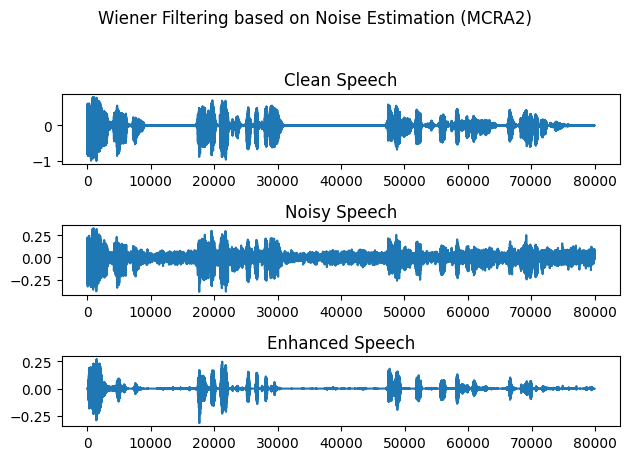

Clean :


Noisy :


Enhanced :


STOI before denoising : 0.883, STOI after : 0.721
PESQ before denoising : 2.006, PESQ after : 1.609


In [ ]:
import numpy as np
import wave
import matplotlib.pyplot as plt
import math
import os

# input wave file
clean_signals = os.listdir(train_small_path + 'original/signal/')
clean_signal = wave.open(train_small_path + 'original/signal/' + clean_signals[2])

# read format information
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
params1 = clean_signal.getparams()
nchannels1, sampwidth1, framerate1, nframes1 = params1[:4]
fs1 = framerate1
# read wave data
str_data1 = clean_signal.readframes(nframes1)
# close .wav file
clean_signal.close()

# convert waveform data to an array
clean = scale_signal(np.fromstring(str_data1, dtype=np.short))

noisy_signals = os.listdir(train_small_path + 'noisy/signal/')
# Load the audio file using librosa
y, sr = librosa.load(train_small_path + 'noisy/signal/' + noisy_signals[2], sr=None)  # sr=None ensures the original sampling rate is used

# y is the waveform and sr is the sampling rate
# If you need the number of channels, sample width, frame rate, etc.
nframes = len(y)
framerate = sr
# close .wav file
clean_signal.close()

# convert waveform data to an array
x = y

# noisy speech FFT
x_FFT = abs(np.fft.fft(x))

# calculation parameters
len_ = 20 * fs // 1000      # frame size in samples
PERC = 50                   # window overlop in percent of frame
len1 = len_ * PERC // 100   # overlop'length
len2 = len_ - len1          # window'length - overlop'length

# setting default parameters
Thres = 3       # VAD threshold in dB SNRseg
Expnt = 2.0
beta = 0.002
G = 0.9

# hamming window
#win = np.hamming(len_)

# sine window
i = np.linspace(0,len_ - 1,len_)
win = np.sqrt(2/(len_ + 1)) * np.sin(np.pi * (i + 1) / (len_ + 1))

# normalization gain for overlap+add with 50% overlap
winGain = len2 / sum(win)

# nFFT = 2 * 2 ** (nextpow2.nextpow2(len_))
nFFT = 2 * 2 ** 8

# initialize various variables
k = 1
img = 1j
x_old = np.zeros(len1)
Nframes = len(x) // len2 - 1
xfinal = np.zeros(Nframes * len2)

# === Start Processing ==== #
for n in range(0, Nframes):

    # Windowing
    insign = win * x[k - 1 : k + len_ - 1]
    # compute fourier transform of a frame
    spec = np.fft.fft(insign, nFFT)
    # compute the magnitude
    sig = abs(spec)
    # noisy speech power spec
    ns_ps = sig ** 2
    # save the noisy phase information
    theta = np.angle(spec)

    # Noise Estimation
    #Init_Weight、ConMinTrack、MCRA、MCRA2
    if n == 0:
        para = Init_MCRA2(ns_ps,fs).info()
    else:
        para = Est_MCRA2(ns_ps,para).est()

    noise_ps = para['noise_ps']
    noise_mu = np.sqrt(noise_ps)

    # Posterior SNR
    SNRpos = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)

    # --- wiener filtering --- #

    # setting SNR
    def berouti(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 4 - SNR * 3 / 20
        else:
            if SNR < -5.0:
                a = 5
            if SNR > 20:
                a = 1
        return a
    def berouti1(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 3 - SNR * 2 / 20
        else:
            if SNR < -5.0:
                a = 4
            if SNR > 20:
                a = 1
        return a

    # setting alpha
    if Expnt == 1.0:     # magnitude spectrum
        alpha = berouti1(SNRpos)
    else:                # power spectrum
        alpha = berouti(SNRpos)

    # 1 over subtraction
    sub_speech = sig ** Expnt - alpha * noise_mu ** Expnt;
    # the pure signal is less than the noise signal power
    diffw = sub_speech - beta * noise_mu ** Expnt
    # beta negative components
    def find_index(x_list):
        index_list = []
        for i in range(len(x_list)):
            if x_list[i] < 0:
                index_list.append(i)
        return index_list
    z = find_index(diffw)
    if len(z) > 0:
        # The lower bound is represented by the estimated noise signal
        for i in range(len(z)):
            sub_speech[z[i]] = beta * noise_mu[z[i]] ** Expnt

    # Priori SNR
    SNRpri = 10 * np.log10(np.linalg.norm(sub_speech ** (1 / Expnt), 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)
    # parameter to deal mel
    mel_max = 10
    mel_0 = (1 + 4 * mel_max) / 5
    s = 25 / (mel_max - 1)
    # deal mel
    def get_mel(SNR):
        if -5.0 <= SNR <= 20.0:
            a = mel_0 - SNR / s
        else:
            if SNR < -5.0:
                a = mel_max
            if SNR > 20:
                a = 1
        return a
    # setting mel
    mel = get_mel(SNRpri)

    # 2 gain function Gk
    G_k = sub_speech / (sub_speech + mel * noise_mu ** Expnt)
    wf_speech = G_k * sig

    # add phase
    #wf_speech[nFFT // 2 + 1:nFFT] = np.flipud(wf_speech[1:nFFT // 2])
    x_phase = wf_speech * np.exp(img * theta)

    # take the IFFT
    xi = np.fft.ifft(x_phase).real

    # --- Overlap and add --- #
    xfinal[k - 1 : k + len2 - 1] = x_old + xi[0 : len1]
    x_old = xi[0 + len1 : len_]

    k = k + len2


wave_data = (winGain * xfinal).astype(np.short)


# enchanced speech FFT
es_FFT = abs(np.fft.fft(winGain * xfinal))

# Create subplots
fig, axs = plt.subplots(3, 1)  # Adjust the figsize as needed
fig.suptitle('Wiener Filtering based on Noise Estimation (MCRA2)')

# Plot clean speech
axs[0].plot(clean)
axs[0].set_title('Clean Speech')

# Plot noisy speech
axs[1].plot(x)
axs[1].set_title('Noisy Speech')

# Plot enhanced speech
axs[2].plot(winGain * xfinal)
axs[2].set_title('Enhanced Speech')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the rect parameter as needed to accommodate the suptitle
plt.show()
print('Clean :')
display(ipd.Audio(clean,rate=8000))
print('Noisy :')
display(ipd.Audio(x,rate=8000))
print('Enhanced :')
display(ipd.Audio(winGain*xfinal,rate=8000))
print(f'STOI before denoising : {compute_STOI(clean,x):.3f}, STOI after : {compute_STOI(clean[:79920],winGain*xfinal):.3f}')
print(f'PESQ before denoising : {compute_PESQ(clean,x):.3f}, PESQ after : {compute_PESQ(clean[:79920],winGain*xfinal):.3f}')

In [ ]:
(winGain*xfinal).shape

(79920,)